# Прогнозирование вероятности оттока пользователей для фитнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

**Цель** — провести анализ и подготовить план действий по удержанию клиентов.

**Задачи:**
* спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

  1) выделить целевые группы клиентов;
  
  2) предложить меры по снижению оттока;
    
  3) определить другие особенности взаимодействия с клиентами.

## Изучение и предобработка файла данных 

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime as dt
from scipy import stats as st
import math as mth

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from scipy.cluster.hierarchy import dendrogram, linkage 

import warnings
warnings.filterwarnings('ignore')
pd.set_option("max_colwidth", 200)

import plotly.io as pio
pio.renderers.default='notebook'

Запишем датасет в переменную df

In [2]:
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('gym_churn.csv')
    
pd.options.display.max_columns = 50

Посмотрим на первые 10 строк и общую информацию о датафрейме

In [3]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [4]:
numeric_cols = df[{'Contract_period', 'Age', 'Avg_additional_charges_total', 
                'Lifetime', 'Avg_class_frequency_total'}]

### Описание данных

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).


Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:


* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

В нашем расположении данные о 4000 клиентах сети фитнес-центров, включающие в себя 13 признаков и одна целевая переменная (*Churn*). Пропуски отсутствуют.

Проверим на наличие дубликатов:

In [5]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


Дубликаты среди представленных данных отсутствуют

### Матрица корреляций

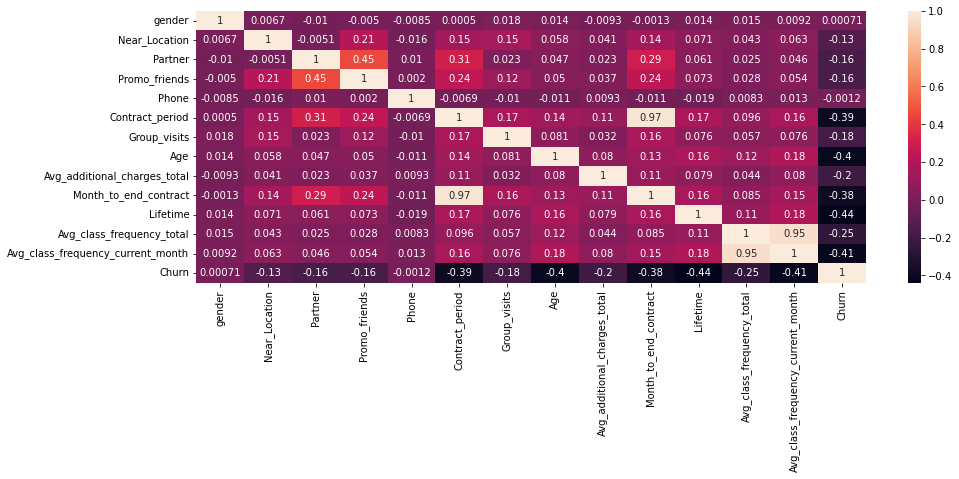

In [6]:
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(df.corr(), annot=True)

Заметная сильная корреляция между средней частотой посещений в неделю за предыдущий месяц и средней частотой посещений в неделю за все время с начала действия абонемента, а также длительности текущего действующего абонемента и срока до окончания текущего действующего абонемента.

Во избежание дальнейших проблем с обученим моделей исключим мультиколлинеарные признаки.

In [8]:
df = df.drop(['Avg_class_frequency_current_month', 'Month_to_end_contract'], axis=1)

### Средние значения и стандартные отклонения

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000


Данные выглядят вполне правдоподобно и значения попадают под описание.

Из них можно составить портрет "среднестатистического" пользователя: мужчина? (1% перевеса) возрастом 29 лет, проживающий или работающий недалко от фитнес-центра, с около 50% вероятностью являющийся сотрудником компании-партнёра клуба, который предоставил телефон для связи, длительность контракта на посещение спорт-зала которого составляет 6 месяцев и не посещающий групповые занятия.

### Гистограммы и распределения признаков

In [10]:
clusters = df.groupby(['Churn'], as_index=False).agg('mean')
clusters

,Churn,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,4.711807,2.024876
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,0.990575,1.474995


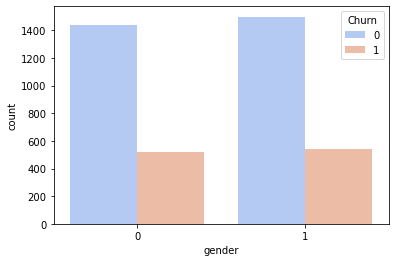

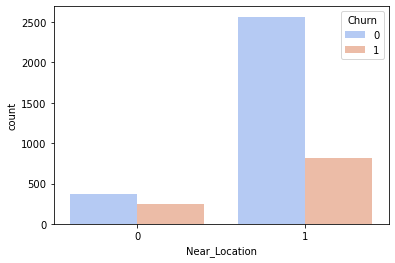

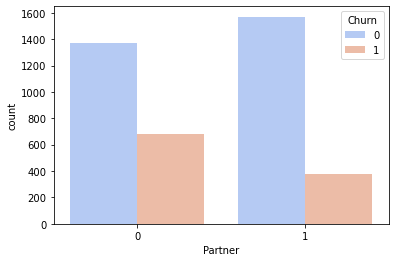

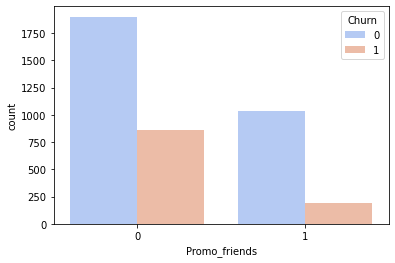

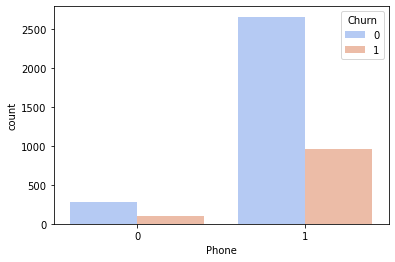

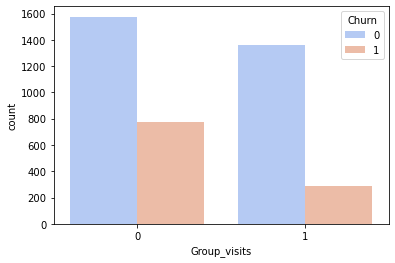

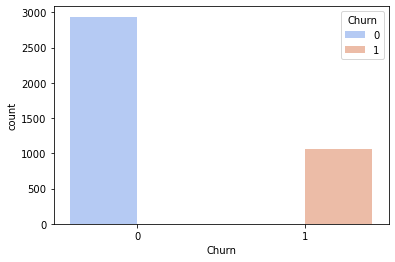

In [11]:
# категориальные значения
for col in df.drop(numeric_cols, axis=1).columns:
    sns.countplot(x=col, data=df, hue='Churn', palette='coolwarm')
    plt.show()

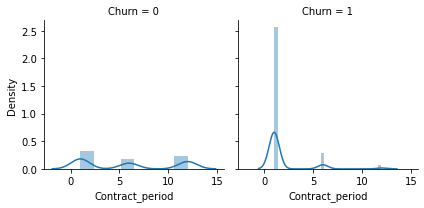

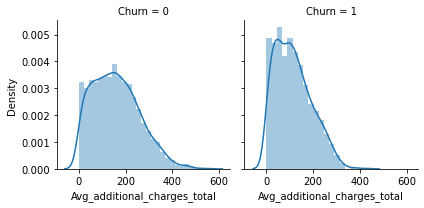

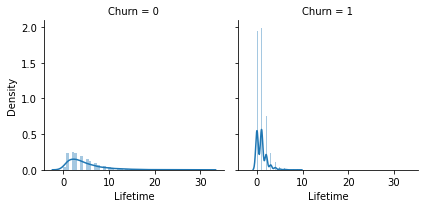

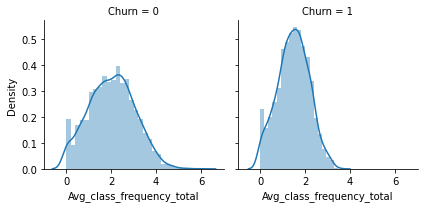

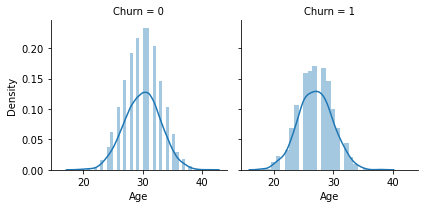

In [12]:
# Количественные поля
for col in numeric_cols.columns:
    t = sns.FacetGrid(df, col='Churn')
    t.map(sns.distplot, col)

**Выводы:**

* Клиенты пришедшие в рамках акции "приведи друга" с большей вероятностью остаются клиенами на более длительный срок. Стоит попробовать устраивать больше таких акций. Те, кто итак являются клиентами фитнес-центра приводят друзей и впоследствии "тянут" друг друга заниматься;
* Средняя длительность контракта влияет на уход клиента. Возможно, когда срок контракта подходит к концу следует сделать небольшую скидку на продление;
* Факт посещения групповых тренировок также влияет на то, как долго клиент остаётся. Это подтверждает первый довод с акцией "приведи друга". "Мы с Тамарой ходим парой" :)
* Клиенты в меньшей степени уходят, если посещают кафе, массажные салоны, покупают снаряжение при фитнес-центре.

## Модель прогнозирования оттока клиентов

### Разбиение данных на обучающую и валидационную выборку

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучение модели на train-выборке

In [14]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

#### Логистическая регрессия

In [15]:
model = LogisticRegression(solver='liblinear')

model.fit(X_train, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
lr_predictions = model.predict(X_test)
lr_probabilities = model.predict_proba(X_test)[:, 1]
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели лигистической регрессии:'
)

Метрики для модели лигистической регрессии:
	Accuracy: 0.90
	Precision: 0.80
	Recall: 0.80
	F1: 0.80
	ROC_AUC: 0.95


#### Случайный лес

In [16]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.78
	F1: 0.80
	ROC_AUC: 0.94


**Выводы:**

Случайный лес показывает более высокие показатели метрик

## Кластеризация клиентов

In [17]:
# Стандартизируем данные

sc = StandardScaler()
x_sc = sc.fit_transform(df)

linked = linkage(x_sc, method = 'ward') 

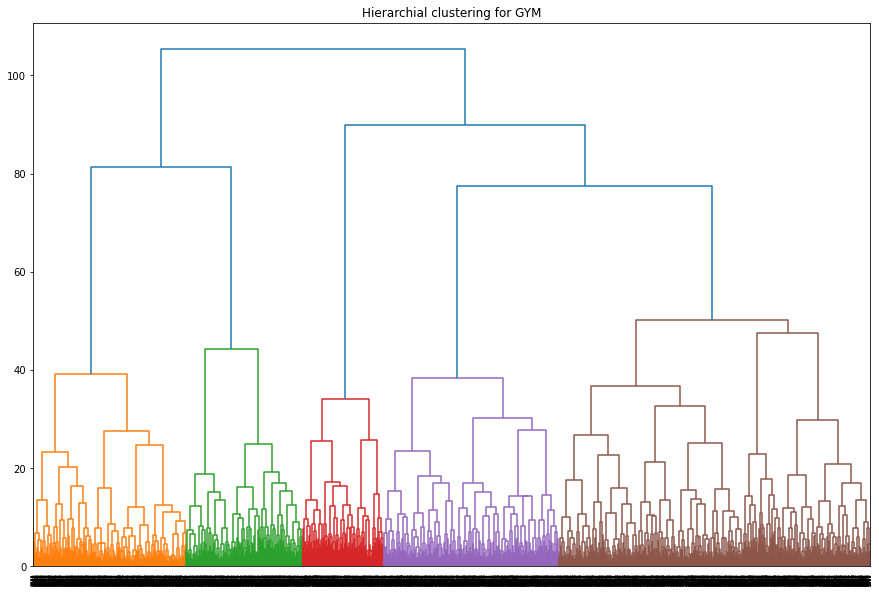

In [18]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

In [19]:
# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
clusters = df.groupby(['cluster_km']).agg('mean').reset_index().sort_values(by='Churn', ascending=True)
display(clusters.T)

,1,3,2,0,4
cluster_km,1.000000,3.000000,2.000000,0.000000,4.000000
gender,0.522936,0.502627,0.503205,0.501661,0.513109
Near_Location,0.999083,0.984238,0.992521,0.000000,1.000000
Partner,0.161468,0.626970,0.916667,0.481728,0.330836
Promo_friends,0.074312,0.000000,1.000000,0.071429,0.217228
Phone,0.902752,0.900175,0.903846,0.911960,0.900125
Contract_period,2.068807,10.623468,7.827991,2.872093,1.682896
Group_visits,0.450459,0.492119,0.544872,0.224252,0.289638
Age,30.055963,29.996497,29.950855,28.652824,26.922597
Avg_additional_charges_total,157.510111,164.623351,159.006129,135.994298,114.095697


In [20]:
numeric_cols = ['Contract_period', 'Age', 'Avg_additional_charges_total', 
                'Lifetime', 'Avg_class_frequency_total']

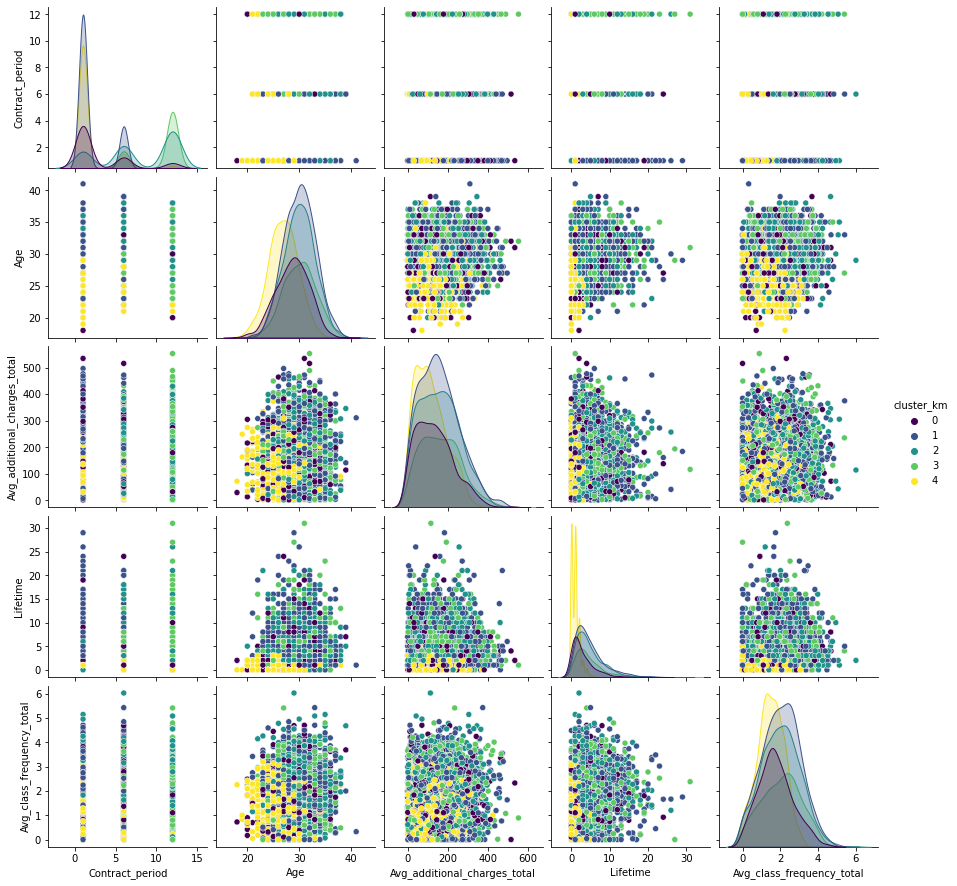

In [21]:
t = sns.pairplot(df[numeric_cols + ['cluster_km']], hue='cluster_km', palette="viridis", diag_kind='kde', height=2.5)

**Выводы:**

Наиболее подвержены к уходу клиенты 5 кластера. Наиболее надёжные - 2, 4, 3, 1.

Отличительная черта ненадёжных клиентов - время с момента первого обращения в фитнес-центр. Если для 5 кластера среднее значение этого показателя 0.96, то для более надёжных - 4.7. Можно сказать, что клиент в большей степени становится надёжным, когда преодолевает барьер в посещении фитнес-клуба в ~28 дней. Иначе говоря, формируется привычка. Также надёжные клиенты тратят больше денег на снаряжение, питание, массаж, а также имеют более длительный контракт и посещают тренировки более чаще. Помимо прочего реже посещают групповые тренировки.

## Общий вывод

По итогу анализа данных проделана предобработка данных, построены матрицы корреляций, графики распределения признаков. Построены модели прогнозирования оттока клиентов (логистическая регрессия и случайный лес). На основе таких метрик, как accuracy, precision, recall, F1 и ROC_AUC определена лучшая модель обучения - логистическая регрессия.

Далее проведена кластеризация пользователей, которая позволила определить долю оттока каждого из кластеров. Наибольшая степень ухода у клиентов 5 кластера. Отличительная черта ненадёжных клиентов - время с момента первого обращения в фитнес-центр. Если для 5 кластера среднее значение этого показателя 0.96, то для более надёжных - 4.7. Можно сказать, что клиент в большей степени становится надёжным, когда преодолевает барьер в посещении фитнес-клуба в ~28 дней. Иначе говоря, формируется привычка. Также надёжные клиенты тратят больше денег на снаряжение, питание, массаж, а также имеют более длительный контракт и посещают тренировки более чаще. Помимо прочего реже посещают групповые тренировки.  

Рекомендации сети фитнес-центров:

* Клиенты пришедшие в рамках акции "приведи друга" с большей вероятностью остаются клиенами на более длительный срок. Стоит попробовать устраивать больше таких акций. Те, кто итак являются клиентами фитнес-центра приводят друзей и впоследствии "тянут" друг друга заниматься;
* Средняя длительность контракта влияет на уход клиента. Возможно, когда срок контракта подходит к концу следует сделать небольшую скидку на продление;
* Факт посещения групповых тренировок также влияет на то, как долго клиент остаётся. Это подтверждает первый довод с акцией "приведи друга". "Мы с Тамарой ходим парой" :)
* Клиенты в меньшей степени уходят, если посещают кафе, массажные салоны, покупают снаряжение при фитнес-центре. Клиенту, у которого есть есть снаряжение не так просто дастся решение прекратить тренировки. Следует попробовать дать перснональные скидки на снаряжение или массаж.